In [348]:
import sys
sys.path.append("../")
sys.path.append("../../../assets")

# Get rid of annoying tf warning
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.backend import clear_session
import bayesflow as beef
import pandas as pd
import pickle

from experiments import NonStationaryDDMExperiment
from models import RandomWalkDDM, MixtureRandomWalkDDM, LevyFlightDDM, RegimeSwitchingDDM

In [ ]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

In [144]:
FIT_MODELS = False

NUM_OBS = 768
NUM_SAMPLES = 1000
NUM_RESIMULATIONS = 500

LOCAL_PARAM_LABELS = ['Drift rate', 'Threshold', 'Non-decision time']
LOCAL_PARAM_NAMES  = [r'v', r'a', r'\tau']
HYPER_PARAM_LABELS = ['Transition std. deviation', 'Switch Probability']
HYPER_PARAM_NAMES  = [r'\sigma', r'q']

COMPARISON_COLOR = '#133a76'

FONT_SIZE_1 = 24
FONT_SIZE_2 = 20
FONT_SIZE_3 = 16

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Palatino"
matplotlib.rcParams['font.family'] = "sans-serif"

In [3]:
rw_ddm = RandomWalkDDM()
rw_ddm_exp = NonStationaryDDMExperiment(
    rw_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_random_walk_ddm"
    )

mrw_ddm = MixtureRandomWalkDDM()
mrw_ddm_exp = NonStationaryDDMExperiment(
    mrw_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_mixture_random_walk_ddm"
    )

lf_ddm = LevyFlightDDM()
lf_ddm_exp = NonStationaryDDMExperiment(
    lf_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_levy_flight_ddm"
    )

rs_ddm = RegimeSwitchingDDM()
rs_ddm_exp = NonStationaryDDMExperiment(
    rs_ddm,
    summary_network_type="smoothing",
    checkpoint_path="../checkpoints/smoothing_regime_switching_ddm"
    )

INFO:root:Performing 2 pilot runs with the random_walk_ddm model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 800)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 3)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 800, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.
INFO:root:Loaded loss history from ../checkpoints/smoothing_random_walk_ddm/history_75.pkl.
INFO:root:Networks loaded from ../checkpoints/smoothing_random_walk_ddm/ckpt-75
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.
INFO:root:Performing 2 pilot runs 

# Inference

In [312]:
data = pd.read_csv('../data/data_color_discrimination.csv')
data['rt'] = np.where(data['correct'] == 0, -data['rt'], data['rt'])

In [313]:
NUM_SUBJECTS = len(np.unique(data['id']))
emp_data = np.zeros((NUM_SUBJECTS, NUM_OBS, 1), dtype=np.float32)
for i in range(NUM_SUBJECTS):
    tmp = data[data['id'] == i+1]
    emp_data[i] = tmp['rt'].to_numpy()[:, np.newaxis]

data['rt'] = np.abs(data['rt'])

In [7]:
if FIT_MODELS:
    rw_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    rw_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 3))
    mrw_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    mrw_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    lf_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    lf_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 5))
    rs_local_samples_z = np.zeros((NUM_SUBJECTS, NUM_OBS, NUM_SAMPLES, 3))
    rs_hyper_samples_z = np.zeros((NUM_SUBJECTS, NUM_SAMPLES, 3))

    with tf.device('/cpu:0'):
        for i in range(NUM_SUBJECTS):
            clear_session()
            tmp_data = {'summary_conditions': emp_data[i:i+1]}
            # random walk ddm
            samples = rw_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            rw_local_samples_z[i] = samples['local_samples']
            rw_hyper_samples_z[i] = samples['global_samples']
            # mixture random walk ddm
            samples = mrw_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            mrw_local_samples_z[i] = samples['local_samples']
            mrw_hyper_samples_z[i] = samples['global_samples']
            # levy flight ddm
            samples = lf_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            lf_local_samples_z[i] = samples['local_samples']
            lf_hyper_samples_z[i] = samples['global_samples']
            # regime switching ddm
            samples = rs_ddm_exp.amortizer.sample(tmp_data, NUM_SAMPLES)
            rs_local_samples_z[i] = samples['local_samples']
            rs_hyper_samples_z[i] = samples['global_samples']

    rw_local_samples = rw_local_samples_z * rw_ddm.local_prior_stds + rw_ddm.local_prior_means
    rw_hyper_samples = rw_hyper_samples_z * rw_ddm.hyper_prior_std + rw_ddm.hyper_prior_mean
    mrw_local_samples = mrw_local_samples_z * mrw_ddm.local_prior_stds + mrw_ddm.local_prior_means
    mrw_hyper_samples = mrw_hyper_samples_z * mrw_ddm.hyper_prior_std + mrw_ddm.hyper_prior_mean
    lf_local_samples = lf_local_samples_z * lf_ddm.local_prior_stds + lf_ddm.local_prior_means
    lf_hyper_samples = lf_hyper_samples_z * lf_ddm.hyper_prior_std + lf_ddm.hyper_prior_mean
    rs_local_samples = rs_local_samples_z * rs_ddm.local_prior_stds + rs_ddm.local_prior_means
    rs_hyper_samples = rs_hyper_samples_z * rs_ddm.hyper_prior_std + rs_ddm.hyper_prior_mean

    np.save("../data/posteriors/rw_local_samples.npy", rw_local_samples)
    np.save("../data/posteriors/rw_hyper_samples.npy", rw_hyper_samples)
    np.save("../data/posteriors/mrw_local_samples.npy", mrw_local_samples)
    np.save("../data/posteriors/mrw_hyper_samples.npy", mrw_hyper_samples)
    np.save("../data/posteriors/lf_local_samples.npy", lf_local_samples)
    np.save("../data/posteriors/lf_hyper_samples.npy", lf_hyper_samples)
    np.save("../data/posteriors/rs_local_samples.npy", rs_local_samples)
    np.save("../data/posteriors/rs_hyper_samples.npy", rs_hyper_samples)
else:
    rw_local_samples = np.load("../data/posteriors/rw_local_samples.npy")
    rw_hyper_samples = np.load("../data/posteriors/rw_hyper_samples.npy")
    mrw_local_samples = np.load("../data/posteriors/mrw_local_samples.npy")
    mrw_hyper_samples = np.load("../data/posteriors/mrw_hyper_samples.npy")
    lf_local_samples = np.load("../data/posteriors/lf_local_samples.npy")
    lf_hyper_samples = np.load("../data/posteriors/lf_hyper_samples.npy")
    rs_local_samples = np.load("../data/posteriors/rs_local_samples.npy")
    rs_hyper_samples = np.load("../data/posteriors/rs_hyper_samples.npy")

# Parameter Trajectories

In [314]:
# get person data
which = 6
person_data = data[data['id'] == which + 1]
condition = person_data['speed_condition'].to_numpy()
idx_speed = []
if condition[0] == 1:
    idx_speed.append([0])
    idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
    idx_speed = np.concatenate(idx_speed)
else:
    idx_speed.append(np.where(condition[:-1] != condition[1:])[0])
    idx_speed.append([NUM_OBS])
    idx_speed = np.concatenate(idx_speed)

In [315]:
# random walk ddm
person_rw_samples = rw_local_samples[which]
rw_post_mean = np.mean(person_rw_samples, axis=1)
rw_post_std = np.std(person_rw_samples, axis=1)
# mixture random walk ddm
person_mrw_samples = mrw_local_samples[which]
mrw_post_mean = np.mean(person_mrw_samples, axis=1)
mrw_post_std = np.std(person_mrw_samples, axis=1)
# levy flight ddm
person_lf_samples = lf_local_samples[which]
lf_post_mean = np.mean(person_lf_samples, axis=1)
lf_post_std = np.std(person_lf_samples, axis=1)
# regime switching ddm
person_rs_samples = rs_local_samples[which]
rs_post_mean = np.mean(person_rs_samples, axis=1)
rs_post_std = np.std(person_rs_samples, axis=1)

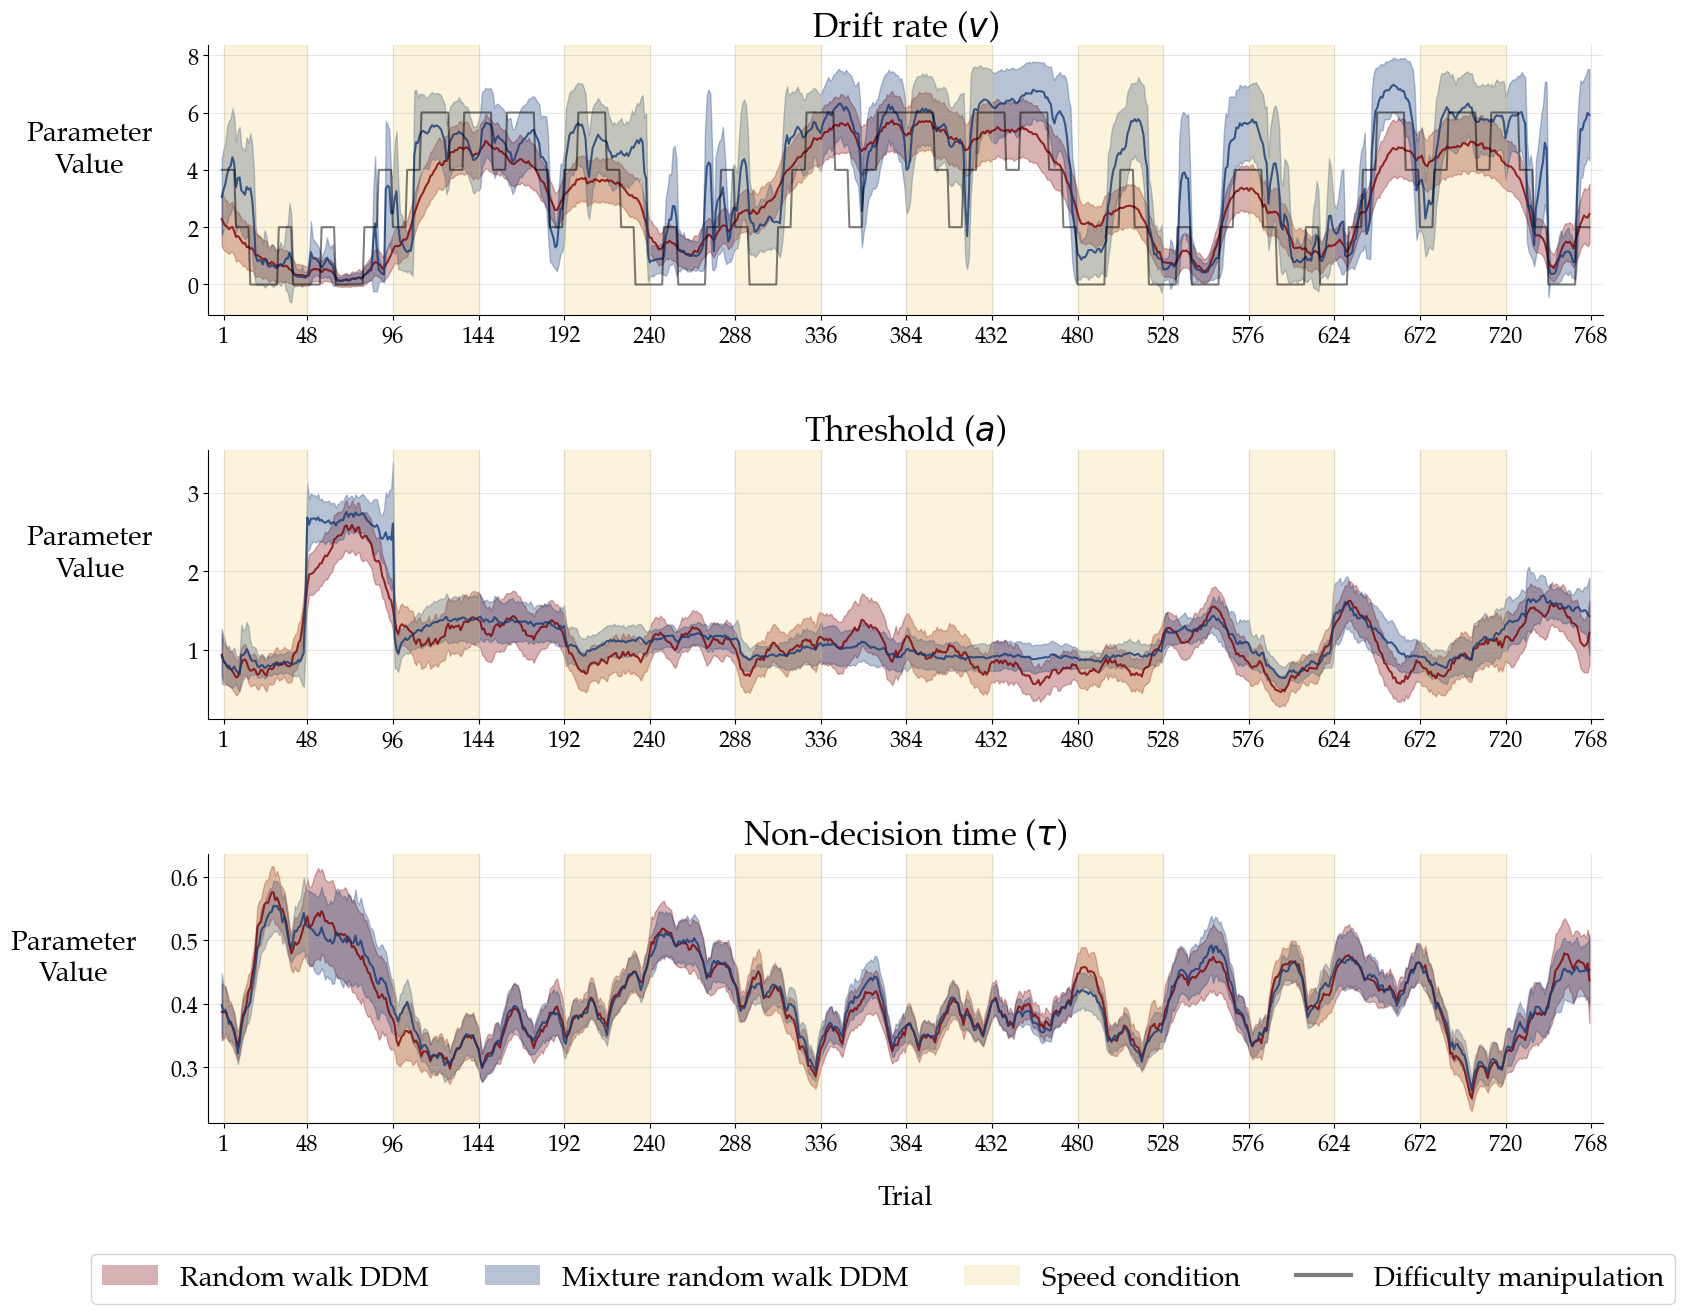

In [316]:
fig, axarr = plt.subplots(3, 1, figsize=(18, 14))
for i, ax in enumerate(axarr.flat):
    # random walk
    ax.fill_between(range(NUM_OBS), rw_post_mean[:, i] - rw_post_std[:, i],
                    rw_post_mean[:, i] + rw_post_std[:, i],
                    color='maroon', alpha=0.3, label="Random walk DDM")
    ax.plot(range(NUM_OBS), rw_post_mean[:, i], color='maroon', alpha=0.8)
    # mixture random walk
    ax.fill_between(range(NUM_OBS), mrw_post_mean[:, i] - mrw_post_std[:, i],
                    mrw_post_mean[:, i] + mrw_post_std[:, i],
                    color=COMPARISON_COLOR, alpha=0.3, label="Mixture random walk DDM")
    ax.plot(range(NUM_OBS), mrw_post_mean[:, i], color=COMPARISON_COLOR, alpha=0.8)
    # # regime switching
    # ax.fill_between(range(NUM_OBS), rs_post_mean[:, i] - rs_post_std[:, i],
    #                 rs_post_mean[:, i] + rs_post_std[:, i],
    #                 color="green", alpha=0.3, label="Regime Switching DDM")
    # ax.plot(range(NUM_OBS), rs_post_mean[:, i], color="green", alpha=0.8)

    # yellow shades
    x = 0
    while x < idx_speed.shape[0]:
        ax.axvspan(idx_speed[x] + 1, idx_speed[x + 1] + 1, alpha=0.2, color='#f0c654', label="Speed condition")
        x = x + 2
    # difficulty manipulation
    if i == 0:
        ax.plot(range(NUM_OBS), (person_data['difficulty'] - 3) * -2, color='black', alpha=0.5, label="Difficulty manipulation")

    # aestehtics
    ax.set_title(f'{LOCAL_PARAM_LABELS[i]} (${LOCAL_PARAM_NAMES[i]}$)', fontsize=FONT_SIZE_1)
    ax.grid(alpha=0.3)
    time = np.arange(0, 768+1, 48)
    time[0] = 1
    ax.set_xticks(time)
    ax.margins(x=0.01)
    ax.tick_params(axis='both', which='major', labelsize=FONT_SIZE_3)
    ax.set_ylabel("Parameter\nValue", rotation=0, labelpad=70, fontsize=FONT_SIZE_2)
    if i == 2:
        ax.set_xlabel("Trial", labelpad=20, fontsize=FONT_SIZE_2)
        
sns.despine()
# fig.tight_layout()
fig.subplots_adjust(hspace=0.5)
# legend
handles = [
    Patch(facecolor='maroon', alpha=0.3, edgecolor=None, label="Random walk DDM"),
    Patch(facecolor=COMPARISON_COLOR, alpha=0.3, edgecolor=None, label="Mixture random walk DDM"),
    Patch(facecolor='#f0c654', alpha=0.2, edgecolor=None, label="Speed condition"),
    Line2D(xdata=[], ydata=[], color='black', alpha=0.5, lw=3, label="Difficulty manipulation")
    ]
fig.legend(
    handles,
    ["Random walk DDM", "Mixture random walk DDM", "Speed condition", "Difficulty manipulation"],
    fontsize=FONT_SIZE_2, bbox_to_anchor=(0.5, -0.001),
    loc="center", ncol=4
    )
# plt.savefig("../plots/param_dynamics.png", dpi=300, bbox_inches="tight")

# Posterior Re-Simulation

In [317]:
idx = np.random.choice(np.arange(NUM_SAMPLES), NUM_RESIMULATIONS, replace=False)

In [319]:
rw_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))
mrw_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))
lf_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))
rs_resim_data = np.zeros((NUM_SUBJECTS, NUM_RESIMULATIONS, NUM_OBS))

rw_samples_t = np.transpose(rw_local_samples, (0, 2, 1, 3))
mrw_samples_t = np.transpose(mrw_local_samples, (0, 2, 1, 3))
lf_samples_t = np.transpose(lf_local_samples, (0, 2, 1, 3))
rs_samples_t = np.transpose(rs_local_samples, (0, 2, 1, 3))
for sub in range(NUM_SUBJECTS):
    rw_resim_data[sub] = rw_ddm.likelihood(rw_samples_t[sub, idx, :, :])['sim_data']
    mrw_resim_data[sub] = mrw_ddm.likelihood(mrw_samples_t[sub, idx, :, :])['sim_data']
    lf_resim_data[sub] = lf_ddm.likelihood(lf_samples_t[sub, idx, :, :])['sim_data']
    rs_resim_data[sub] = rs_ddm.likelihood(rs_samples_t[sub, idx, :, :])['sim_data']

In [349]:
rw_samples_t

array([[[[ 7.46095526e-01,  8.38663876e-01,  3.94058573e-01],
         [ 1.02076549e+00,  9.14472580e-01,  2.79902864e-01],
         [ 5.66799402e-02,  1.08510864e+00,  2.58106995e-01],
         ...,
         [ 2.82837626e+00,  1.70293993e+00,  3.41604996e-01],
         [ 3.93408415e+00,  9.66351151e-01,  4.08279884e-01],
         [ 3.39338064e+00,  1.37705860e+00,  3.69467366e-01]],

        [[ 3.76927853e-04,  1.46070713e+00,  2.90185261e-01],
         [ 2.19375241e-01,  1.38783339e+00,  3.30623794e-01],
         [-1.19632483e-03,  8.61799717e-01,  2.94828701e-01],
         ...,
         [ 4.09971985e+00,  1.85407548e+00,  2.69109535e-01],
         [ 2.66902244e+00,  2.15810805e+00,  2.61899638e-01],
         [ 3.63730275e+00,  1.41876185e+00,  3.73627710e-01]],

        [[ 1.21230289e+00,  1.32205409e+00,  2.96132135e-01],
         [ 4.94463205e-01,  9.77030814e-01,  3.54599047e-01],
         [ 7.30877829e-01,  1.11845681e+00,  3.39455235e-01],
         ...,
         [ 2.91140294e+0

In [343]:
which = 6
person_pred = mrw_resim_data[which+1]
person_data = data.loc[data.id == which]

In [344]:
person_pred_mean = person_pred.mean(axis=0)

In [345]:
test_df = pd.DataFrame({
    'speed_condition': person_data['speed_condition'],
    'difficulty': person_data['difficulty'],
    'rt': person_pred_mean,
    })

In [346]:
grouped = test_df.groupby(['speed_condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['mean', 'std']
})
summary

rt          
                                mean       std
speed_condition difficulty                    
0               0           0.443712  0.147104
                1           0.479981  0.147500
                2           0.513642  0.144833
                3           0.517318  0.139804
1               0           0.334521  0.080975
                1           0.358191  0.077571
                2           0.346911  0.087145
                3           0.330427  0.062787

In [347]:
grouped = person_data.groupby(['speed_condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['mean', 'std']
})
summary

rt          
                                mean       std
speed_condition difficulty                    
0               0           0.675640  0.340767
                1           0.671200  0.232925
                2           0.911163  0.456872
                3           1.303323  0.581616
1               0           0.463953  0.064161
                1           0.505879  0.088860
                2           0.569060  0.129633
                3           0.575494  0.093363

In [332]:
person_post_mean = person_post.mean(axis=0)
person_pred = mrw.likelihood.simulator()

In [333]:
person_post_mean.shape

(768,)

In [320]:
id = np.repeat(data['id'], NUM_RESIMULATIONS)
sim = np.tile(np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS), NUM_SUBJECTS)

condition = []
difficulty = []
for sub in data['id'].unique():
    condition.append(np.tile(data.loc[data.id == sub, 'speed_condition'], NUM_RESIMULATIONS))
    difficulty.append(np.tile(data.loc[data.id == sub, 'difficulty'], NUM_RESIMULATIONS))
condition = np.concatenate(condition)
difficulty = np.concatenate(difficulty)

In [ ]:
rw_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(rw_resim_data.flatten()),
    })
mrw_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(mrw_resim_data.flatten()),
    })
lf_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(lf_resim_data.flatten()),
    })
rs_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(rs_resim_data.flatten()),
    })

In [327]:
grouped = mrw_resim_df.groupby(['condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['mean', 'std']
})
summary

rt          
                          mean       std
condition difficulty                    
0         0           0.605454  0.305194
          1           0.633184  0.365940
          2           0.675780  0.426378
          3           0.672309  0.408917
1         0           0.656597  0.417472
          1           0.628027  0.357110
          2           0.648695  0.391830
          3           0.653830  0.348998

In [329]:
grouped = data.groupby(['speed_condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['mean', 'std']
})
summary

rt          
                                mean       std
speed_condition difficulty                    
0               0           0.558101  0.196529
                1           0.606156  0.211502
                2           0.767949  0.342118
                3           0.965411  0.492023
1               0           0.454721  0.088978
                1           0.482590  0.092284
                2           0.529834  0.120762
                3           0.564972  0.129600

In [310]:
condition = np.tile(data.loc[data.id == which, 'speed_condition'], NUM_RESIMULATIONS)
difficulty = np.tile(data.loc[data.id == which, 'difficulty'], NUM_RESIMULATIONS)

In [276]:
rt = []
for i in range(NUM_RESIMULATIONS):
    rt.append(rw_resim_data[which+1, i, :])
rt = np.concatenate(rt)

In [277]:
test_df = pd.DataFrame({
    'condition': condition,
    'difficulty': difficulty,
    'rt': rt,
    })

In [278]:
grouped = test_df.groupby(['condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median', 'std']
})
summary

rt          
                        median       std
condition difficulty                    
0         0           0.454421  0.464195
          1           0.467715  0.490220
          2           0.480494  0.492755
          3           0.468734  0.512022
1         0           0.617851  1.034197
          1           0.517998  0.660516
          2           0.523397  0.484211
          3           0.553134  0.469874

In [272]:
grouped = test_df.groupby(['condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median', 'mad']
})
summary

rt          
                        median       std
condition difficulty                    
0         0           0.454421  0.464195
          1           0.467715  0.490220
          2           0.480494  0.492755
          3           0.468734  0.512022
1         0           0.617851  1.034197
          1           0.517998  0.660516
          2           0.523397  0.484211
          3           0.553134  0.469874

In [280]:
id = np.repeat(data['id'], NUM_RESIMULATIONS)
sim = np.tile(np.repeat(np.arange(NUM_RESIMULATIONS), NUM_OBS), NUM_SUBJECTS)

condition = []
difficulty = []
rw_rt = []
for sub in data['id'].unique():
    condition.append(np.tile(data.loc[data.id == sub, 'speed_condition'], NUM_RESIMULATIONS))
    difficulty.append(np.tile(data.loc[data.id == sub, 'difficulty'], NUM_RESIMULATIONS))
    rw_rt.append(np.abs(rw_resim_data[sub-1].flatten()))
condition = np.concatenate(condition)
difficulty = np.concatenate(difficulty)
rw_rt = np.concatenate(rw_rt)

In [311]:
rw_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': rw_rt,
    })
# rw_resim_df = pd.DataFrame({
#     'sim': sim,
#     'id': id,
#     'condition': condition,
#     'difficulty': difficulty,
#     'rt': np.abs(rw_resim_data.flatten()),
#     })
mrw_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(mrw_resim_data.flatten()),
    })
lf_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(lf_resim_data.flatten()),
    })
rs_resim_df = pd.DataFrame({
    'sim': sim,
    'id': id,
    'condition': condition,
    'difficulty': difficulty,
    'rt': np.abs(rs_resim_data.flatten()),
    })

ValueError: All arrays must be of the same length

In [282]:
rw_resim_df

,sim,id,condition,difficulty,rt
0,0,1,1,1,0.581829
0,0,1,1,1,0.657079
0,0,1,1,1,0.322948
0,0,1,1,1,0.429475
0,0,1,1,1,0.295944
...,...,...,...,...,...
10751,499,14,1,2,0.459681
10751,499,14,1,2,0.699084
10751,499,14,1,2,0.470519
10751,499,14,1,2,0.521297


In [242]:
rw_resim_df.loc[rw_resim_df.id == 1]

,sim,id,condition,difficulty,rt
0,0,1,1,1,1.005829
0,0,1,1,1,1.101079
0,0,1,1,1,0.622948
0,0,1,1,1,0.636475
0,0,1,1,1,0.364944
...,...,...,...,...,...
767,499,1,0,1,1.060681
767,499,1,0,1,1.107084
767,499,1,0,1,0.870519
767,499,1,0,1,0.607297


In [283]:
grouped = rw_resim_df.loc[rw_resim_df.id == 3].groupby(['condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median', 'std']
})
summary

rt          
                        median       std
condition difficulty                    
0         0           0.486661  0.206812
          1           0.506817  0.194415
          2           0.518664  0.188221
          3           0.514672  0.196498
1         0           0.771668  0.593500
          1           0.570306  0.405700
          2           0.550439  0.271493
          3           0.581450  0.245072

In [284]:
grouped = test_df.groupby(['condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median', 'count']
})
summary

rt       
                        median  count
condition difficulty                 
0         0           0.454421  48000
          1           0.467715  48000
          2           0.480494  48000
          3           0.468734  48000
1         0           0.617851  48000
          1           0.517998  48000
          2           0.523397  48000
          3           0.553134  48000

In [285]:
grouped = data.loc[data.id == 3].groupby(['speed_condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median']
})

summary

rt
                              median
speed_condition difficulty          
0               0           0.463660
                1           0.490969
                2           0.532388
                3           0.567263
1               0           0.429900
                1           0.450557
                2           0.484300
                3           0.445003

In [288]:
rw_resim_data.shape

(14, 500, 768)

In [290]:
test_data = rw_resim_data[which+1].mean(axis=0)

In [295]:
data.loc[data.id == which, 'rt']

1536    1.568344
1537    0.509066
1538    0.772682
1539   -1.840895
1540   -1.275566
          ...   
2299    0.440357
2300    0.597034
2301    0.631423
2302    0.670859
2303    0.523301
Name: rt, Length: 768, dtype: float64

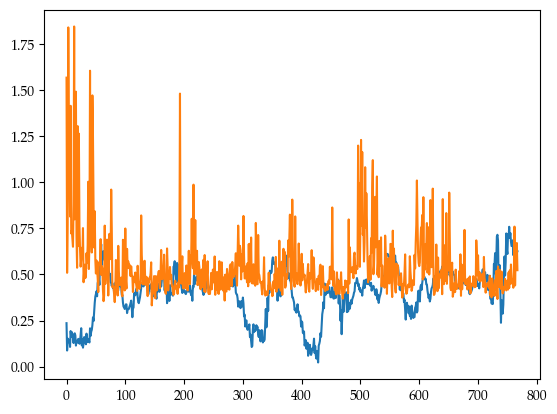

In [298]:
plt.plot(np.arange(NUM_OBS), test_data)
plt.plot(np.arange(NUM_OBS), np.abs(data.loc[data.id == which, 'rt']))

In [300]:
rw_post_mean.shape

(768, 3)

In [304]:
test_data = rw_ddm.likelihood.simulator(rw_post_mean)


In [305]:
test_df = pd.DataFrame({
    'condition': data.loc[data.id == which, "speed_condition"],
    'difficulty': data.loc[data.id == which, "difficulty"],
    'rt': np.abs(test_data),
    })

In [306]:
grouped = test_df.groupby(['condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median', 'count']
})
summary

rt      
                        median count
condition difficulty                
0         0           0.708305    96
          1           0.641571    96
          2           0.662624    96
          3           0.643071    96
1         0           0.477989    96
          1           0.495224    96
          2           0.459163    96
          3           0.466005    96

In [308]:
data.rt = np.abs(data.rt)

In [309]:
grouped = data.loc[data.id == 3].groupby(['speed_condition', 'difficulty'])
summary = grouped.agg({
    'rt': ['median']
})

summary

rt
                              median
speed_condition difficulty          
0               0           0.464785
                1           0.491158
                2           0.553574
                3           0.684982
1               0           0.429900
                1           0.450557
                2           0.493850
                3           0.526464